# Featurization, Model Selection & Tuning

### Objective
Modeling of strength of high performance concrete using Machine Learning.

### Context
Concrete is the most important material in civil engineering. The concrete compressive strength is a highly nonlinear function of it's age and ingredients. The actual concrete compressive strength for a given mixture under a specific age was determined in laboratory and data was quantified into 8 input variables and 1 quantitative output variable. In total, we had 1030 observations. 

In [37]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from sklearn import metrics
from scipy.stats import zscore
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline 

### Reading Dataset

In [2]:
c_data = pd.read_csv('concrete.csv')
c_data.head(10)

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29
5,255.0,0.0,0.0,192.0,0.0,889.8,945.0,90,21.86
6,166.8,250.2,0.0,203.5,0.0,975.6,692.6,7,15.75
7,251.4,0.0,118.3,188.5,6.4,1028.4,757.7,56,36.64
8,296.0,0.0,0.0,192.0,0.0,1085.0,765.0,28,21.65
9,155.0,184.0,143.0,194.0,9.0,880.0,699.0,28,28.99


In [3]:
# Get number of rows and columns
c_data.shape

(1030, 9)

In [4]:
# Get information about column data types and non-null values
c_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [5]:
# Get number of missing values in each column
c_data.isnull().sum().sort_values() 

cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64

In [6]:
c_data.describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


#### Observations

- Dataframe has 1030 rows and 9 columns.
- No NULL/empty values in the dataset as of yet.
- All columns are numerical in nature. All coulmns except 'age' are floating-point values and 'age' and integer.

### Exploratory Data Analysis

#### Univariate Analysis

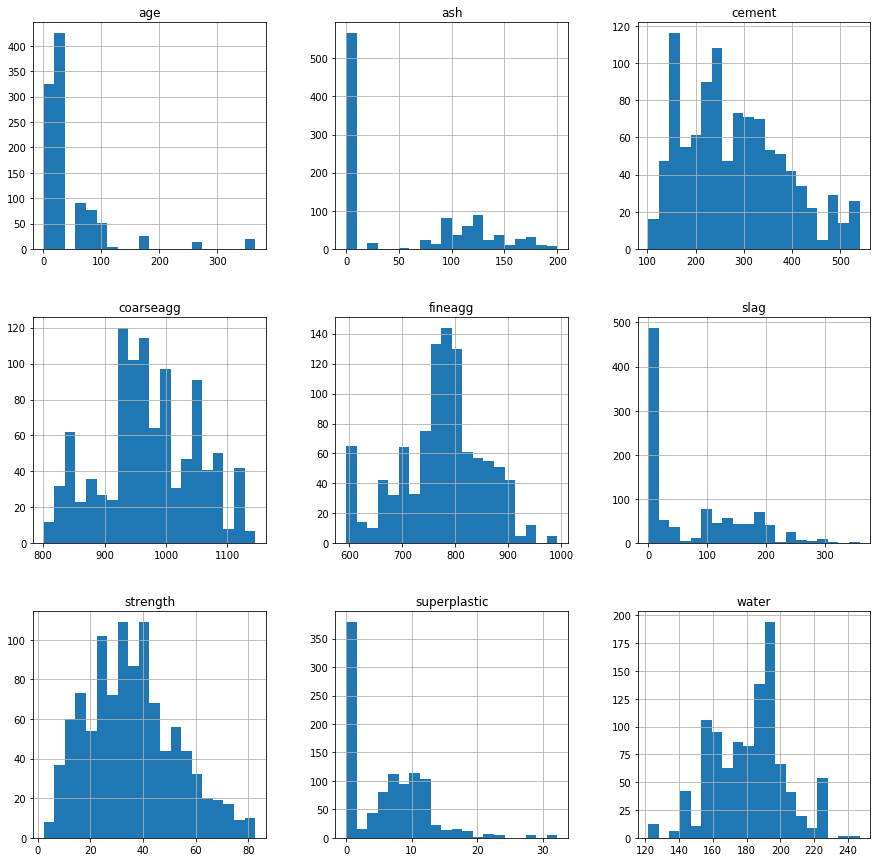

In [7]:
# Check how each columns are distributed
c_data.hist(bins=20, figsize=(15,15));

In [8]:
# Calculating number of ouliers per column

df = c_data
Q1 = c_data.quantile(q = 0.25) 
Q3 = c_data.quantile(q = 0.75) 
IQR = Q3 - Q1

((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum().sort_values()

cement           0
ash              0
coarseagg        0
slag             2
strength         4
fineagg          5
water            9
superplastic    10
age             59
dtype: int64

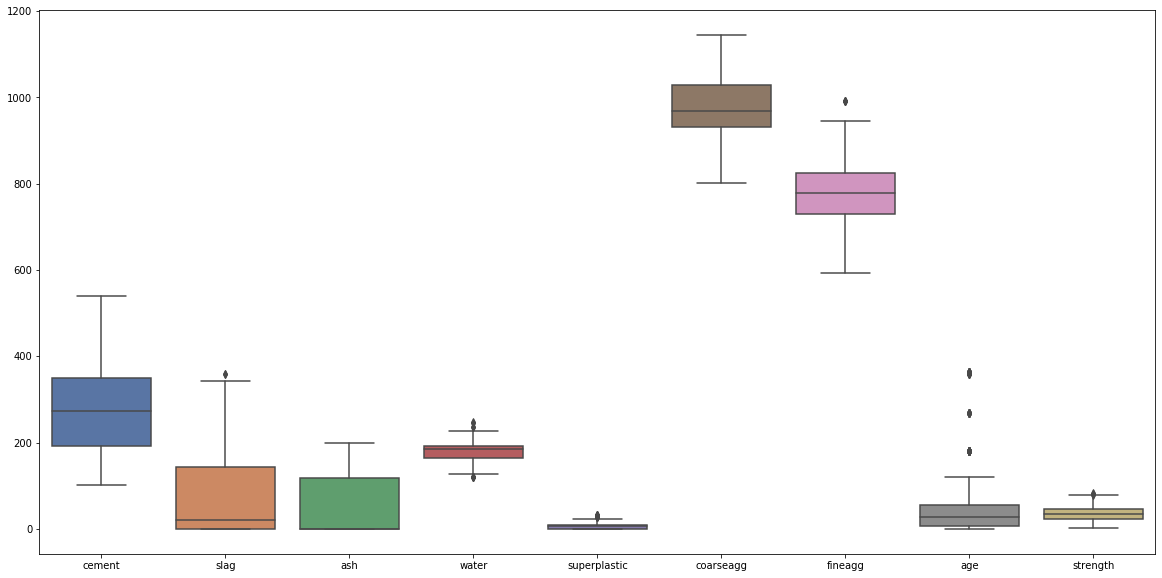

In [9]:
# Checking for outliers

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sns.set(font_scale=1.5)
sns.boxplot(data=c_data);

#### Observations

- From the boxplot, it shows that slag, ash, water superplastic, and age have outliers.
- Attributes 'cement', 'slag' & 'ash' are left skewed, whereas 'age' and 'superplastic' are skewed towards right.

#### Bivariate Analysis

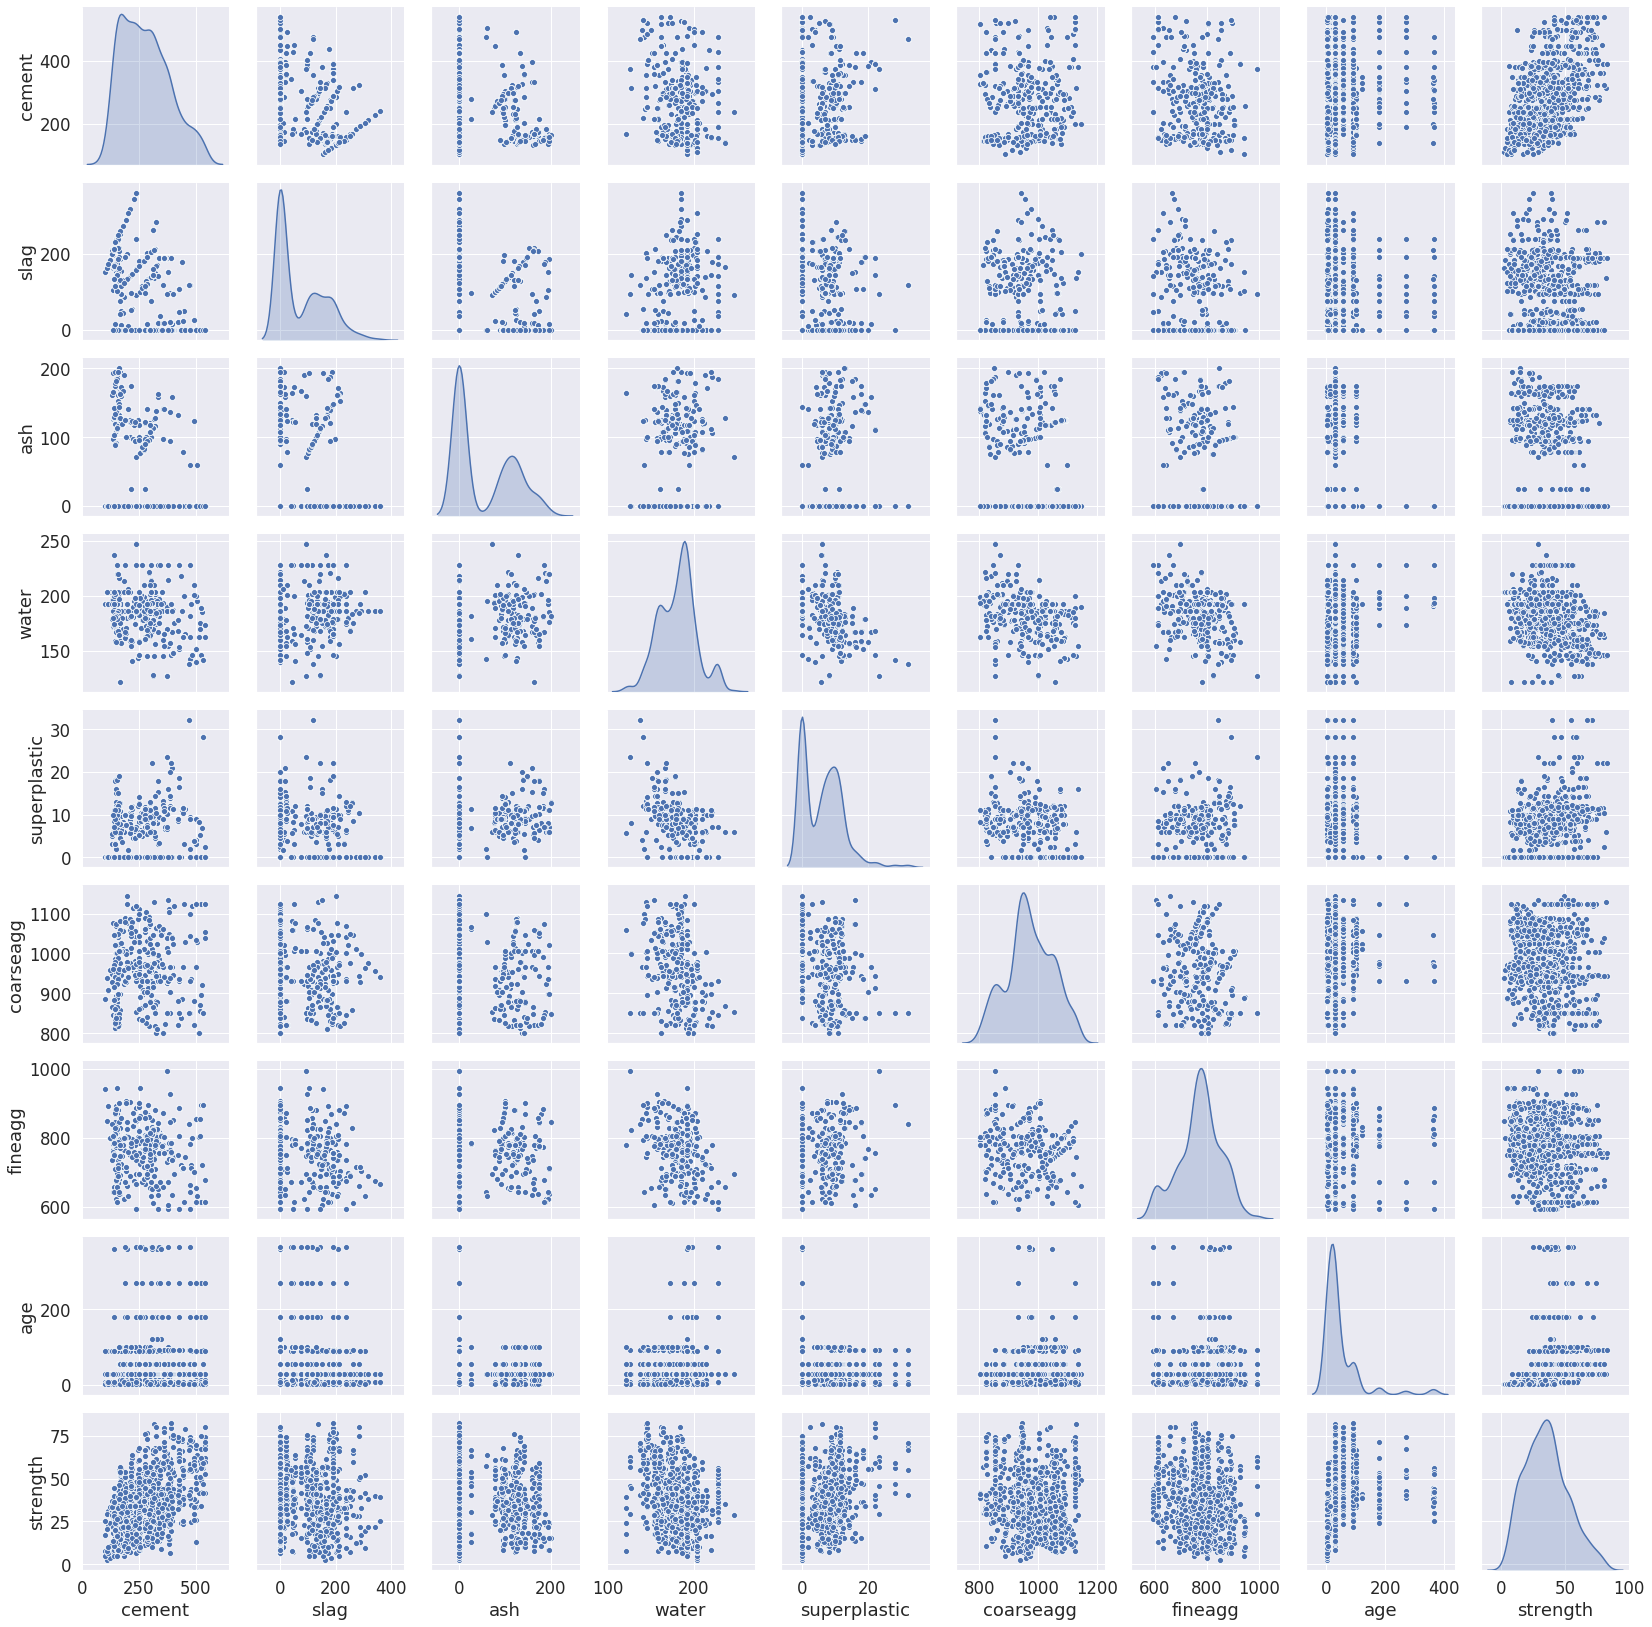

In [10]:
sns.pairplot(c_data, diag_kind='kde');

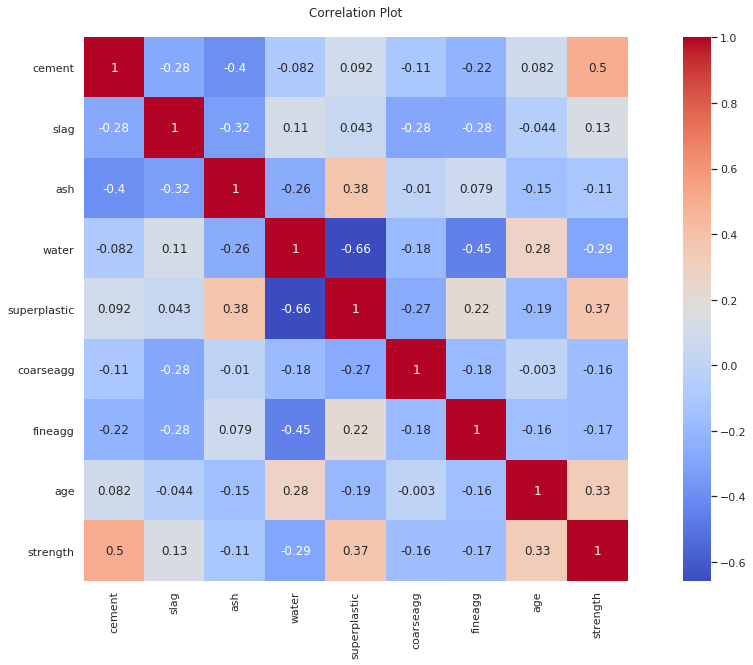

In [11]:
# Correaltion

correlation = c_data.corr()
sns.set(font_scale=1)
plt.figure(figsize=(20, 10))
plt.title("Correlation Plot\n")
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='coolwarm');

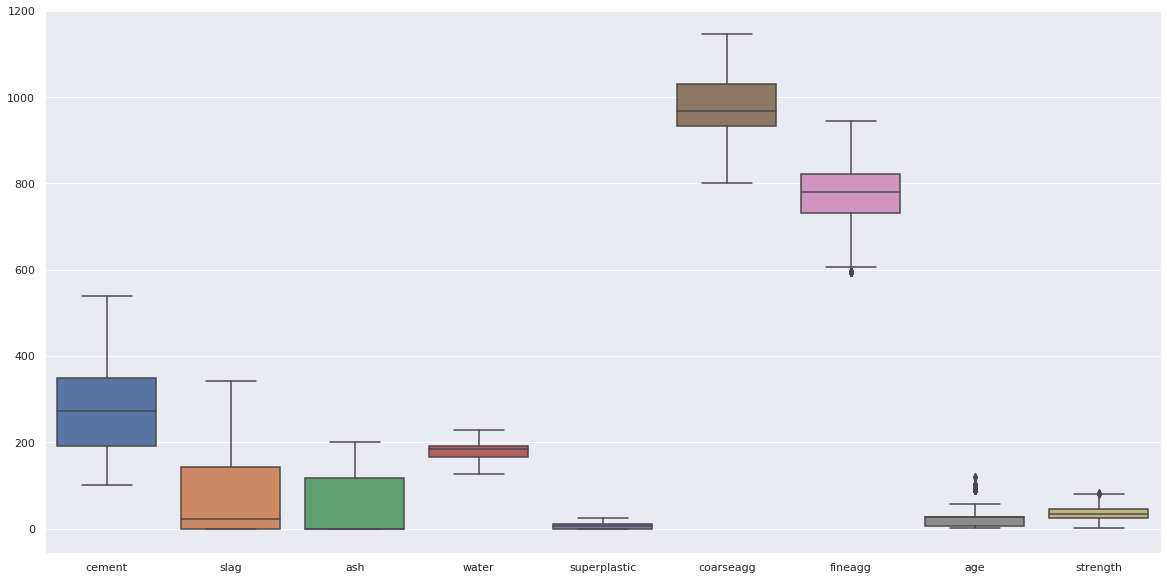

In [12]:
# Treating the outliers

concrete_df = c_data.copy()         # Making a copy of the original dataset

for col_name in concrete_df.columns[:-1]:
    q1 = concrete_df[col_name].quantile(0.25)
    q3 = concrete_df[col_name].quantile(0.75)
    iqr = q3 - q1
    
    low = q1-1.5*iqr
    high = q3+1.5*iqr
    
    concrete_df.loc[(concrete_df[col_name] < low) | (concrete_df[col_name] > high), col_name] = concrete_df[col_name].median()

# Plotting boxplot to check outlier treatment    
    
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sns.set(font_scale=1.5)
sns.boxplot(data=concrete_df);

#### Observations

- No high correlation between any two features. 
- 'Water' and 'superplastic' are negetively correlated.
- Slight positive correlation between 'cement' and 'strength'.
- Some attributes had outlier, which has been treated and imputed with their respective medians.
- None of the independent attributes are a good predictors of the strength attribute as there is a no linear relationship between them. Thus we will not be using a linear model

### Featurization, Model Building and Tuning

#### Splitting dataset

In [13]:
# Scaling the dataset

concrete_scaled = concrete_df.apply(zscore)
concrete_scaled = pd.DataFrame(concrete_scaled, columns=c_data.columns)
concrete_scaled.head(10)

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,-1.339017,1.625902,-0.847144,1.060879,-1.091166,-0.014398,-0.305676,-0.153159,-0.355018
1,-1.074790,-0.363717,1.096078,-1.134020,0.881615,1.388141,0.300692,-0.656933,-0.737108
2,-0.298384,-0.858192,0.648965,0.279067,-0.086509,-0.206121,1.126981,-0.153159,-0.395144
3,-0.145209,0.477594,-0.847144,2.250592,-1.091166,-0.526517,-1.303578,-0.153159,0.600806
4,-1.209776,1.290784,-0.847144,0.565570,0.571085,0.958372,-0.964165,-0.153159,-1.049727
5,-0.250517,-0.858192,-0.847144,0.502442,-1.091166,-1.069519,2.192258,2.077843,-0.835925
6,-1.094894,2.073508,-0.847144,1.060879,-1.091166,0.034498,-1.016284,-0.908821,-1.201845
7,-0.284981,-0.858192,1.002278,0.332483,0.077890,0.713893,-0.188725,0.854391,0.049231
8,0.141995,-0.858192,-0.847144,0.502442,-1.091166,1.442184,-0.095926,-0.153159,-0.848501
9,-1.207861,1.297814,1.388421,0.599562,0.552818,-1.195619,-0.934927,-0.153159,-0.408918


In [14]:
# Splitting dataset into training and testing set

X = concrete_scaled.iloc[:,0:8]
y = concrete_scaled.iloc[:,8]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

### Train and evaluate models
#### a) Linear Regression

In [15]:
lr = LinearRegression()
lr.fit(X, y);

In [16]:
y_pred = lr.predict(X_test)

print('Accuracy on training data:', "{:.2%}".format(lr.score(X_train,y_train)))
print('Accuracy on testing data:', "{:.2%}".format(lr.score(X_test,y_test)))

lr_accuracy = metrics.r2_score(y_test, y_pred)
print('Accuracy: ', "{:.2%}".format(lr_accuracy))

Accuracy on training data: 71.95%
Accuracy on testing data: 70.90%
Accuracy:  70.90%


- In the case of linear regressor model, the performance is similar in the case of training and testing data.
- However like we deduced earlier, since no independent variables are strong predictors of the target variable, model accuracy is low.

#### b) Decision Tree Regression

In [17]:
dt = DecisionTreeRegressor()
dt.fit(X_train , y_train);

In [18]:
#printing the feature importance
print('Feature importances: \n\n',pd.DataFrame(dt.feature_importances_,columns=['Importance'],index=X_train.columns))

Feature importances: 

               Importance
cement          0.354992
slag            0.094347
ash             0.012996
water           0.127712
superplastic    0.015629
coarseagg       0.035593
fineagg         0.030135
age             0.328595


- Here 'cement', 'water' and 'age' are considered significant attributes.
- Therefore the remaining are the less significant variable and hence these will impact less to the strength

In [19]:
y_pred = dt.predict(X_test)

print('Accuracy on training data:', "{:.2%}".format(dt.score(X_train,y_train)))
print('Accuracy on testing data:', "{:.2%}".format(dt.score(X_test,y_test)))

dt_accuracy = metrics.r2_score(y_test, y_pred)
print('Accuracy: ', "{:.2%}".format(dt_accuracy))

Accuracy on training data: 99.18%
Accuracy on testing data: 84.82%
Accuracy:  84.82%


- Decision tree regressor overfits the model as the dataset is performing 99% accurately in trainnig set, but accuracy drops on test data.

#### K fold - Decision Tree Regression

In [20]:
kfold = KFold(n_splits=5, random_state=50)
cross_val = cross_val_score(dt, X, y, cv=kfold)
dtk_accuracy = np.mean(cross_val)

print('Accuracy: ', "{:.2%}".format(dtk_accuracy))

Accuracy:  84.65%


#### c) Random Forest Regressor

In [21]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train);

In [22]:
y_pred = rf.predict(X_test)

print('Accuracy on training data:', "{:.2%}".format(rf.score(X_train,y_train)))
print('Accuracy on testing data:', "{:.2%}".format(rf.score(X_test,y_test)))

rf_accuracy = metrics.r2_score(y_test, y_pred)
print('Accuracy: ', "{:.2%}".format(rf_accuracy))

Accuracy on training data: 97.96%
Accuracy on testing data: 90.07%
Accuracy:  90.07%


- Random Forest overfits the model as the dataset is performing 98% accurately in trainnig set, but accuracy drops on test data.

#### K fold - Random Forest

In [23]:
kfold = KFold(n_splits=5, random_state=50)
cross_val = cross_val_score(rf, X, y, cv=kfold)
rfk_accuracy = np.mean(cross_val)

print('Accuracy: ', "{:.2%}".format(rfk_accuracy))

Accuracy:  90.02%


#### d) Gradient Boosting Regressor

In [24]:
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train);

In [25]:
y_pred = gb.predict(X_test)

print('Accuracy on training data:', "{:.2%}".format(gb.score(X_train,y_train)))
print('Accuracy on testing data:', "{:.2%}".format(gb.score(X_test,y_test)))

gb_accuracy = metrics.r2_score(y_test, y_pred)
print('Accuracy: ', "{:.2%}".format(gb_accuracy))

Accuracy on training data: 94.30%
Accuracy on testing data: 89.15%
Accuracy:  89.15%


- Gradient Booster overfits the model as the dataset is performing 94% accurately in trainnig set, but accuracy drops on test data.

#### K fold - Gradient Booster

In [26]:
kfold = KFold(n_splits=5, random_state=50)
cross_val = cross_val_score(gb, X, y, cv=kfold)
gbk_accuracy = np.mean(cross_val)

print('Accuracy: ', "{:.2%}".format(gbk_accuracy))

Accuracy:  89.30%


#### e) Ada Boosting Regressor

In [27]:
ab = AdaBoostRegressor()
ab.fit(X_train, y_train);

In [28]:
y_pred = ab.predict(X_test)

print('Accuracy on training data:', "{:.2%}".format(ab.score(X_train,y_train)))
print('Accuracy on testing data:', "{:.2%}".format(ab.score(X_test,y_test)))

ab_accuracy = metrics.r2_score(y_test, y_pred)
print('Accuracy: ', "{:.2%}".format(ab_accuracy))

Accuracy on training data: 81.59%
Accuracy on testing data: 76.43%
Accuracy:  76.43%


- Gradient Booster overfits the model as the dataset is performing 81% accurately in trainnig set, but accuracy drops on test data.

#### K fold - Ada Boosting

In [29]:
kfold = KFold(n_splits=5, random_state=50)
cross_val = cross_val_score(ab, X, y, cv=kfold)
abk_accuracy = np.mean(cross_val)

print('Accuracy: ', "{:.2%}".format(abk_accuracy))

Accuracy:  76.84%


#### f) Bagging Regressor

In [30]:
br = BaggingRegressor()
br.fit(X_train, y_train);

In [31]:
y_pred = br.predict(X_test)

print('Accuracy on training data:', "{:.2%}".format(br.score(X_train,y_train)))
print('Accuracy on testing data:', "{:.2%}".format(br.score(X_test,y_test)))

br_accuracy = metrics.r2_score(y_test, y_pred)
print('Accuracy: ', "{:.2%}".format(br_accuracy))

Accuracy on training data: 97.52%
Accuracy on testing data: 88.75%
Accuracy:  88.75%


- Gradient Booster overfits the model as the dataset is performing 97% accurately in trainnig set, but accuracy drops on test data.

#### K fold - Bagging

In [32]:
kfold = KFold(n_splits=5, random_state=50)
cross_val = cross_val_score(br, X, y, cv=kfold)
brk_accuracy = np.mean(cross_val)

print('Accuracy: ', "{:.2%}".format(brk_accuracy))

Accuracy:  88.75%


### Assessing Model Performance

In [33]:
accuracy = np.array([lr_accuracy, dt_accuracy, dtk_accuracy, rf_accuracy, 
                     rfk_accuracy, gb_accuracy, gbk_accuracy, ab_accuracy, 
                     abk_accuracy, br_accuracy, brk_accuracy]).T

In [34]:
result = pd.DataFrame({'Model' : ['Logistic Regression', 'Decision Tree', 'Decision Tree K Fold',
                                  'Random Forest', 'Random Forest K Fold', 'Gradient boost', 'Gradient boost K Fold',
                                  'Ada boost', 'Ada boost K Fold', 'Bagging', 'Bagging K Fold'], 
                       'Accuracy' : accuracy})
result

,Model,Accuracy
0,Logistic Regression,0.708998
1,Decision Tree,0.848171
2,Decision Tree K Fold,0.846522
3,Random Forest,0.900720
4,Random Forest K Fold,0.900193
5,Gradient boost,0.891459
6,Gradient boost K Fold,0.893021
7,Ada boost,0.764256
8,Ada boost K Fold,0.768392
9,Bagging,0.887530


#### Observation

- We can see that Random Forest Regressor, Random Forest Regressor k fold, Gradient Boost Regressor, Gradient Boost Regressor k fold, Bagging Regressor and Bagging regressor k fold are giving better results as compared to other models.
- Out of which, the random forest model is better than other algorithms.

### Model performance range at 95% confidence level

In [39]:
concrete_XY = X.join(y)
values = concrete_XY.values

n_iterations = 1000  
n_size = int(len(concrete_scaled) * 1)    

stats = list()   
for i in range(n_iterations):
    
    train = resample(values, n_samples=n_size)  
    test = np.array([x for x in values if x.tolist() not in train.tolist()])

    rfTree = RandomForestRegressor(n_estimators=100)
    rfTree.fit(train[:,:-1], train[:,-1]) 
    y_test = test[:,-1]    

    score = rfTree.score(test[:, :-1] , y_test)
    predictions = rfTree.predict(test[:, :-1])  
    stats.append(score)

# confidence intervals

alpha = 0.95                             
p = ((1-alpha)/2) * 100 
lower = max(0, np.percentile(stats, p))  
p = (alpha + ((1-alpha)/2)) * 100
upper = min(1.0, np.percentile(stats, p))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

95.0 confidence interval 84.3% and 90.7%


### Conclusion

- The random forest model performance is between 84.3% - 90.7% which is better than other classification algorithms.